<a href="https://colab.research.google.com/github/Nikita-Gz/ArGen2/blob/main/ArGen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental notebook, showing how to achieve interesting effects with untrained neural networks, creative algebra, and mathematical visual effects

General principle: use an untrained neural network to transform a matrix, which contains pixel coordinates on its last dimension, into a matrix of pixel colors

The coordinate matrix has the dimensions of [-1, X, Y, 2], where dimensions X and Y correspond to the X and Y position on the target image, and the last dimension contains the values of the coordinates (usually scaled down).

To have additional effects across the image, the input matrix can be concatenated with other matrices on its last dimension. The coordinate plane itself can be edited as well

In [1]:
!pip install ffmpeg-python

In [2]:
import numpy as np
from typing import Any, Callable

In [3]:
def create_plane(resolution: tuple[int, int], scale: float) -> np.array:
    """ Creates a coordinate plane of specified resolution and coordinates scale,
    with the last dimension of length 2 being the coordinates """
    x = resolution[0]
    y = resolution[1]
    smallest_side = min(x, y)

    # the coordinate values are scaled so that the smallest axist matches the scale
    x_range = np.linspace(-scale, scale, x) * x / smallest_side
    y_range = -np.linspace(-scale, scale, y) * y / smallest_side

    x_grid, y_grid = np.meshgrid(x_range, y_range)
    coordinate_plane = np.dstack((x_grid, y_grid))
    return coordinate_plane

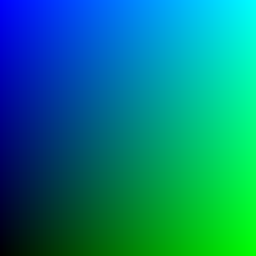

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

def matrix_to_image(matrix, min_val=-1, max_val=1, resolution=(256, 256)) -> Image:
    """ Converts a [X, Y, 1-3] matrix into a PIL Image. Assumes that the minimal
    and maximal values that can be present in the matrix are specified in
    min_val and max_val respectively """
    normalized_matrix = np.clip(matrix, min_val, max_val)
    normalized_matrix = (normalized_matrix - min_val) / (max_val - min_val)

    # Convert to image to BW if it has 1 axis only, or BG and BR if 2 axises,
    # or full RGB if 3 axises
    color_matrix = np.zeros((*matrix.shape[:2], 3))
    match matrix.shape[2]:
        case 1:
            color_matrix[:, :, 0] = normalized_matrix[:, :, 0]  # R
            color_matrix[:, :, 1] = normalized_matrix[:, :, 0]  # G
            color_matrix[:, :, 2] = normalized_matrix[:, :, 0]  # B
        case 2:
            color_matrix[:, :, 0] = 0  # R
            color_matrix[:, :, 1] = normalized_matrix[:, :, 0]  # G
            color_matrix[:, :, 2] = normalized_matrix[:, :, 1]  # B
        case 3:
            color_matrix = normalized_matrix
        case _:
            raise ValueError(f"Invalid matrix shape: {normalized_matrix.shape}")

    gradient_uint8 = (color_matrix * 255).astype(np.uint8)

    img = Image.fromarray(gradient_uint8)
    return img


plane = create_plane((256, 256), 1)
matrix_to_image(plane)

# Effects matrices

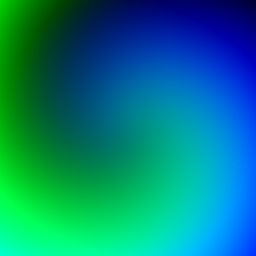

In [5]:
def rotate_around_center(coordinate_plane, center=(0, 0), scale=1, phase=0) -> np.array:
    """ Transforms the coordinate plane by spiraling it across the center point """
    x_coords, y_coords = coordinate_plane[:, :, 0], coordinate_plane[:, :, 1]
    distance_to_center = np.sqrt((x_coords - center[0])**2 + (y_coords - center[1])**2)

    # Calculate angle of rotation for each point relative to the center
    angle = np.arctan2(y_coords - center[1], x_coords - center[0])

    # Apply rotation based on distance from center
    rotated_x = center[0] + (x_coords - center[0]) * np.cos(scale * distance_to_center + phase) - (y_coords - center[1]) * np.sin(scale * distance_to_center + phase)
    rotated_y = center[1] + (x_coords - center[0]) * np.sin(scale * distance_to_center + phase) + (y_coords - center[1]) * np.cos(scale * distance_to_center + phase)

    return np.dstack((rotated_x, rotated_y))

matrix_to_image(rotate_around_center(create_plane((256, 256), 1), scale=2))

<ipython-input-6-54211bfb3ddb>:16: RuntimeWarning: invalid value encountered in divide
  coordinate_plane_unit_vectors = coordinate_plane / np.linalg.norm(coordinate_plane, axis=-1, keepdims=True)


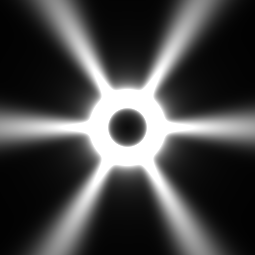

In [6]:
def generate_asterisk_pattern(
        coordinate_plane,
        center=(0, 0),
        num_rays=8,
        ray_width=0.1,
        ray_falloff=0.5,
        center_width=0.2,
        center_outer_ring_falloff=100,
        center_inner_ring_falloff=500) -> np.array:
    """Creates an effect i am experimenting on currently, which resemples the "*"
    sign, with rays stratching from the centre. Except the centre is actually
    a hollow ring"""
    initial_distances = np.linalg.norm(coordinate_plane - center, axis=-1, keepdims=True)

    # "stretches" the coordinate plane to create a ring around the centre, filling it with NaN instead
    coordinate_plane_unit_vectors = coordinate_plane / np.linalg.norm(coordinate_plane, axis=-1, keepdims=True)
    coordinate_plane = np.where(
        initial_distances < center_width,
        np.nan,
        coordinate_plane - coordinate_plane_unit_vectors * center_width)
    x_coords, y_coords = coordinate_plane[:, :, 0], coordinate_plane[:, :, 1]
    altered_distance_to_center = np.linalg.norm(coordinate_plane - center, axis=-1)

    asterisk_pattern = np.zeros_like(altered_distance_to_center)
    angle = np.arctan2(y_coords - center[1], x_coords - center[0])
    for ray_i in range(num_rays):
        ray_angle = ray_i * 2 * np.pi / num_rays
        angle_diff = np.abs(angle - ray_angle)

        # Clamps the angles
        angle_diff = np.minimum(angle_diff, 2*np.pi - angle_diff)

        # Applies intensity based on angle difference from the ray
        asterisk_pattern += np.exp(-angle_diff**2 / (2 * ray_width**2)) / (1 + (altered_distance_to_center**2) * ray_falloff)

    # Fills the outer part of the central ring
    center_outer_ring = (1 / altered_distance_to_center**2) / center_outer_ring_falloff
    asterisk_pattern += center_outer_ring

    # Fills the inner part of the central ring
    center_inner_ring = np.where(
        initial_distances[:, :, 0] < center_width,
        (1 / (center_width - initial_distances[:, :, 0])**2) / (center_inner_ring_falloff),
        0)
    asterisk_pattern[np.isnan(altered_distance_to_center)] = 0
    asterisk_pattern += center_inner_ring

    return np.expand_dims(asterisk_pattern, axis=-1)

plane = create_plane((255, 255), 1)
astr = generate_asterisk_pattern(plane, num_rays=6, center_width=0.2, ray_falloff=1)
matrix_to_image(astr, 0, 1)

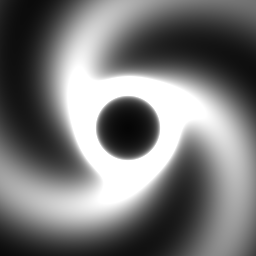

In [7]:
# By giving the rotated matrix to the asterisk pattern generator,
# we can get a spiraling pattern!
matrix_to_image(
    generate_asterisk_pattern(
        rotate_around_center(
            create_plane((256, 256), 1),
            scale=1.8,
            phase=np.pi / 4),
        num_rays=3,
        ray_width=0.4,
        ray_falloff=1,
        center_width=0.3),
    min_val=0)

# Using random neural networks for colors

In [8]:
import keras
import tensorflow as tf

class SplitActivation(keras.layers.Layer):
    '''
    Custom keras layer that the splits last dimension and passes it through
    different activation functions. The layer is split equally if possible,
    unless split_config is specified

    This code is from 2020. Please do not judge
    '''

    def __init__(self, activations, split_config=None, split_dim=-1, **kwargs):
        self._split_dim = split_dim
        self._activations = activations
        self._activations_amount = len(self._activations)
        self._is_config_a_list = isinstance(split_config, list)
        self._split_config = None

        # assert that split_config size matches with activations amount
        if self._is_config_a_list:
            assert len(split_config) == self._activations_amount, (
                'length of activation sizes list ({}) does not match length of '
                'activations list ({})'
                .format(len(split_config), self._activations_amount))
            self._split_config = split_config
        else:
            self._split_config = self._activations_amount

        super(SplitActivation, self).__init__(**kwargs)

    def build(self, input_shape):
        split_dim_size = input_shape[self._split_dim]

        if self._is_config_a_list:
            assert sum(self._split_config) == split_dim_size, (
            'sum of split sizes ({}) does not match the split dimension size ({})'
            .format(sum(self._split_config), split_dim_size))
        else:
            assert (split_dim_size % self._activations_amount) == 0, (
            'last dimension (size {}) cannot be evenly split across '
            'activations (size {})'
            .format(split_dim_size, self._activations_amount))

        super(SplitActivation, self).build(input_shape)


    def call(self, x):
        split_input = tf.split(x, self._split_config, axis=self._split_dim)

        x = tf.concat([activation(input_slice) for input_slice, activation
                        in zip(split_input, self._activations)],
                        axis=self._split_dim)
        return x


In [9]:
def process_array_in_parts(array, processing_function, divide_by_n_parts=8):
    """
    Processing input in parts is useful in case the operation uses a lot of memory
    """
    blocks = np.array_split(array, divide_by_n_parts, axis=0)
    outputs = []
    for i, block in enumerate(blocks):
        print("processing block " + str(i+1) + " out of " + str(len(blocks)))
        result = processing_function(block)
        outputs.append(result)

    final_result = np.concatenate(outputs)
    return final_result

In [10]:
from matplotlib.colors import hsv_to_rgb

def postprocessing_effect(colors: np.array) -> np.array:
    """
    Creates an interesting purple effect with sharp contours.
    "colors" is an HSV [..., 3] array.
    """

    original_colors_matrix = np.copy(colors)

    # this forces the purple color
    colors[..., 0] = 0.8

    # this ensures that the saturation is at least a half
    colors[..., 1] = 0.5 + original_colors_matrix[..., 1] * 0.5

    # this makes the brightness be sharper and more erratic
    colors[..., 2] = original_colors_matrix[..., 2] **2 + original_colors_matrix[..., 0] **2

    return hsv_to_rgb(colors)

In [11]:
# This network structure creates my favourite pattern by far
staircase_generator = keras.Sequential([
    keras.layers.Dense(16,
                        bias_initializer=keras.initializers.RandomNormal(0, 0.5)),
    SplitActivation([tf.nn.relu, tf.math.sin]),
    keras.layers.Dense(16,
                        bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                        #bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
    SplitActivation([tf.nn.relu, tf.math.ceil]),
    keras.layers.Dense(16,
                        kernel_initializer=keras.initializers.RandomNormal(0, 0.1),
                        bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
    SplitActivation([tf.nn.relu, tf.math.sin]),

    keras.layers.Dense(3,
                        activation='tanh'),
])

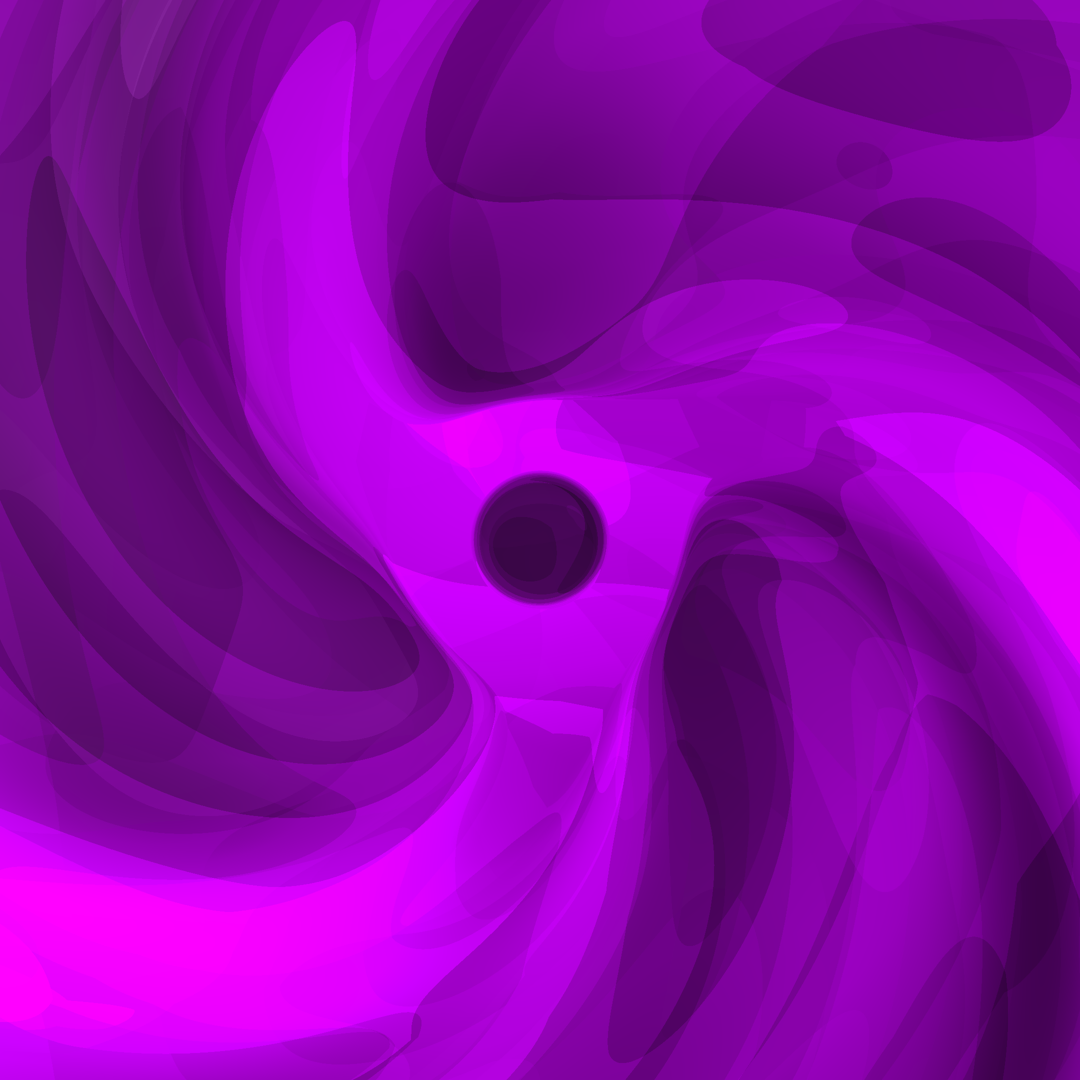

In [12]:
def generate_input_matrix(
        resolution: tuple[int, int],
        coordinates_scale: float,
        asterisk_rotation: float,
        coordinates_rotation: float,
        oscilator_progress: float,
        oscilator_scale: float) -> np.array:
    """
    Creates an effect based on theb ase coordinate plane and the asterisk pattern
    rotating at different phases.
    Also adds two oscilating image-wide values
    """
    image_coordinates_plane = rotate_around_center(
        create_plane(resolution, coordinates_scale),
        scale=0.1,
        phase=coordinates_rotation)

    asterisk_coordinates_plane = rotate_around_center(
        create_plane(resolution, coordinates_scale),
        scale=0.1,
        phase=asterisk_rotation)
    asterisk_pattern = generate_asterisk_pattern(
        asterisk_coordinates_plane,
        num_rays=3,
        ray_width=0.5,
        ray_falloff=0.001,
        center_width=2,
        center_inner_ring_falloff=2,
        center_outer_ring_falloff=4)

    # makes the effect more sharp and noticeable
    asterisk_pattern = (np.clip(asterisk_pattern, 0, 1) ** 3) * 10

    # display(matrix_to_image(asterisk_pattern, min_val=0, max_val=1))

    ones = np.ones_like(asterisk_pattern)
    oscilator1 = np.sin(oscilator_progress) * oscilator_scale * ones
    oscilator2 = np.cos(oscilator_progress) * oscilator_scale * ones

    input_matrix = np.concatenate([
        image_coordinates_plane,
        asterisk_pattern,
        oscilator1,
        oscilator2], axis=-1)
    input_matrix = input_matrix[np.newaxis, ...]
    return input_matrix

input_matrix = generate_input_matrix(
    resolution=(2160, 2160),
    coordinates_scale=10,
    asterisk_rotation=20,
    coordinates_rotation=20,
    oscilator_progress=0,
    oscilator_scale=2)
staircase = (staircase_generator(input_matrix).numpy()[0] + 1) / 2
img = matrix_to_image(postprocessing_effect(staircase), min_val=0, max_val=1)
img.resize((1080, 1080), resample=Image.BICUBIC)

# Video generation code

In [ ]:
from dataclasses import dataclass


@dataclass
class Keyframe:
    time: float
    value: Any
    interpolation: Callable | None = None


def linear_interpolation(start_keyframe: Keyframe, end_keyframe: Keyframe, time: float) -> float:
    delta_t = end_keyframe.time - start_keyframe.time
    if delta_t == 0:
        return start_keyframe.value

    keyframe_progress = (time - start_keyframe.time) / delta_t
    return start_keyframe.value * (1 - keyframe_progress) + end_keyframe.value * keyframe_progress


class AnimationParameter:
    """Represents parameters in the animation, allowing for interpolation
    between the keyframes as time goes on. If the interpolation function is not
    provided for the keyframe, does linear interpolation by default"""
    def __init__(
            self,
            keyframes: list[Keyframe],
            default_interpolation: Callable = linear_interpolation):
        self._keyframes = sorted(keyframes, key=lambda kf: kf.time)
        self.default_interpolation = default_interpolation


    def __call__(self, time: float) -> Any:
        if len(self._keyframes) == 1:
            return self._keyframes[0].value

        # Finds the keyframes surrounding the given time, assumes they're sorted
        # Todo: maybe implement it without loop, as a challenge?
        prev_keyframe = None
        next_keyframe = None
        for keyframe in self._keyframes:
            if keyframe.time <= time:
                prev_keyframe = keyframe
            if keyframe.time >= time:
                next_keyframe = keyframe
            if prev_keyframe is not None and next_keyframe is not None:
                break
        if prev_keyframe is None:
            return self._keyframes[0].value
        if next_keyframe is None:
            return self._keyframes[-1].value

        interpolation_func = prev_keyframe.interpolation or self.default_interpolation
        return interpolation_func(prev_keyframe, next_keyframe, time)

In [ ]:
import ffmpeg

def get_video_writer(resolution: tuple[int, int], fps: int, crf=15):
    writer = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s=f'{resolution[0]}x{resolution[1]}', r=fps)
            .output('animation.mp4', pix_fmt='yuv420p', crf=crf, vcodec='h264')
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    return writer

Creating frame 1 out of 1200


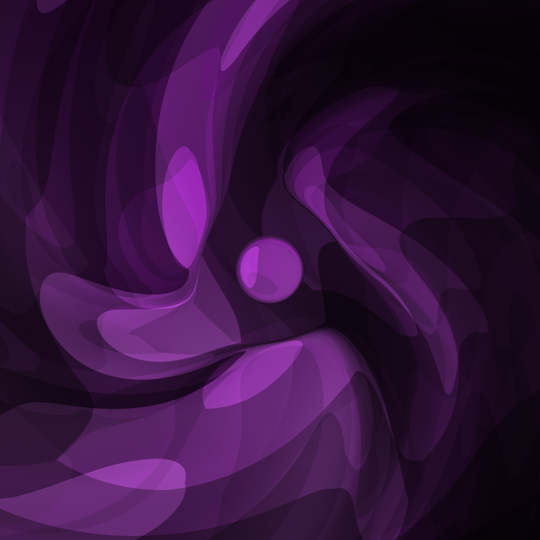

Created frame 1 out of 1200
Creating frame 2 out of 1200
Created frame 2 out of 1200
Creating frame 3 out of 1200
Created frame 3 out of 1200
Creating frame 4 out of 1200
Created frame 4 out of 1200
Creating frame 5 out of 1200
Created frame 5 out of 1200
Creating frame 6 out of 1200
Created frame 6 out of 1200
Creating frame 7 out of 1200
Created frame 7 out of 1200
Creating frame 8 out of 1200
Created frame 8 out of 1200
Creating frame 9 out of 1200
Created frame 9 out of 1200
Creating frame 10 out of 1200
Created frame 10 out of 1200
Creating frame 11 out of 1200
Created frame 11 out of 1200
Creating frame 12 out of 1200
Created frame 12 out of 1200
Creating frame 13 out of 1200
Created frame 13 out of 1200
Creating frame 14 out of 1200
Created frame 14 out of 1200
Creating frame 15 out of 1200
Created frame 15 out of 1200
Creating frame 16 out of 1200
Created frame 16 out of 1200
Creating frame 17 out of 1200
Created frame 17 out of 1200
Creating frame 18 out of 1200
Created frame 

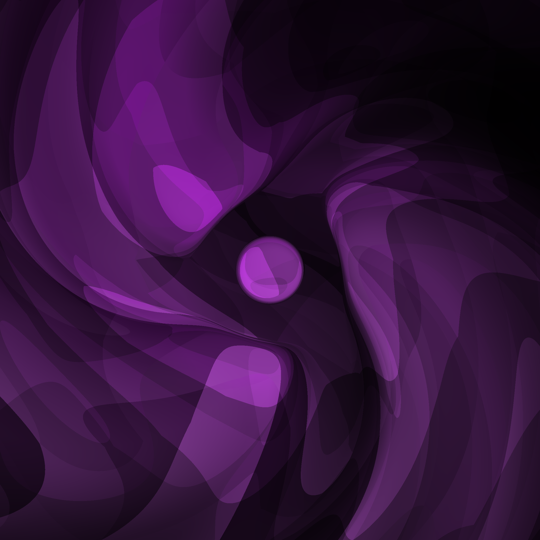

Created frame 101 out of 1200
Creating frame 102 out of 1200
Created frame 102 out of 1200
Creating frame 103 out of 1200
Created frame 103 out of 1200
Creating frame 104 out of 1200
Created frame 104 out of 1200
Creating frame 105 out of 1200
Created frame 105 out of 1200
Creating frame 106 out of 1200
Created frame 106 out of 1200
Creating frame 107 out of 1200
Created frame 107 out of 1200
Creating frame 108 out of 1200
Created frame 108 out of 1200
Creating frame 109 out of 1200
Created frame 109 out of 1200
Creating frame 110 out of 1200
Created frame 110 out of 1200
Creating frame 111 out of 1200
Created frame 111 out of 1200
Creating frame 112 out of 1200
Created frame 112 out of 1200
Creating frame 113 out of 1200
Created frame 113 out of 1200
Creating frame 114 out of 1200
Created frame 114 out of 1200
Creating frame 115 out of 1200
Created frame 115 out of 1200
Creating frame 116 out of 1200
Created frame 116 out of 1200
Creating frame 117 out of 1200
Created frame 117 out of

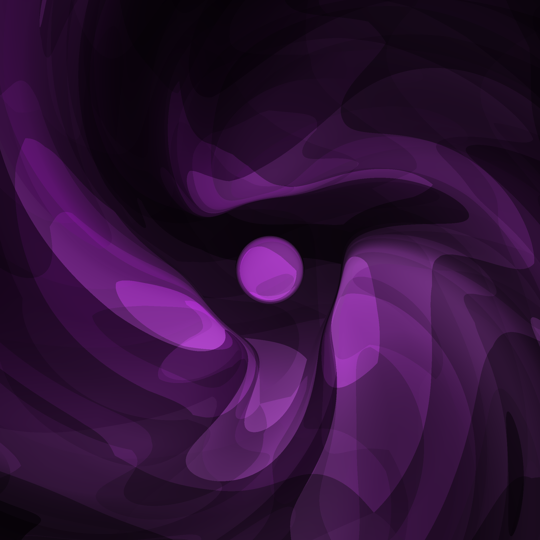

Created frame 201 out of 1200
Creating frame 202 out of 1200
Created frame 202 out of 1200
Creating frame 203 out of 1200
Created frame 203 out of 1200
Creating frame 204 out of 1200
Created frame 204 out of 1200
Creating frame 205 out of 1200
Created frame 205 out of 1200
Creating frame 206 out of 1200
Created frame 206 out of 1200
Creating frame 207 out of 1200
Created frame 207 out of 1200
Creating frame 208 out of 1200
Created frame 208 out of 1200
Creating frame 209 out of 1200
Created frame 209 out of 1200
Creating frame 210 out of 1200
Created frame 210 out of 1200
Creating frame 211 out of 1200
Created frame 211 out of 1200
Creating frame 212 out of 1200
Created frame 212 out of 1200
Creating frame 213 out of 1200
Created frame 213 out of 1200
Creating frame 214 out of 1200
Created frame 214 out of 1200
Creating frame 215 out of 1200
Created frame 215 out of 1200
Creating frame 216 out of 1200
Created frame 216 out of 1200
Creating frame 217 out of 1200
Created frame 217 out of

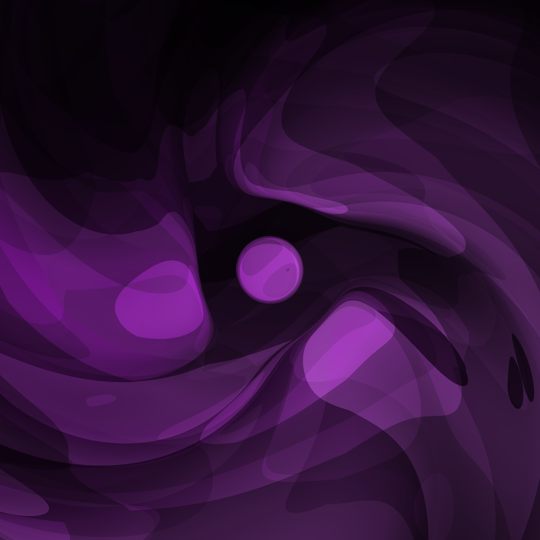

Created frame 301 out of 1200
Creating frame 302 out of 1200
Created frame 302 out of 1200
Creating frame 303 out of 1200
Created frame 303 out of 1200
Creating frame 304 out of 1200
Created frame 304 out of 1200
Creating frame 305 out of 1200
Created frame 305 out of 1200
Creating frame 306 out of 1200
Created frame 306 out of 1200
Creating frame 307 out of 1200
Created frame 307 out of 1200
Creating frame 308 out of 1200
Created frame 308 out of 1200
Creating frame 309 out of 1200
Created frame 309 out of 1200
Creating frame 310 out of 1200
Created frame 310 out of 1200
Creating frame 311 out of 1200
Created frame 311 out of 1200
Creating frame 312 out of 1200
Created frame 312 out of 1200
Creating frame 313 out of 1200
Created frame 313 out of 1200
Creating frame 314 out of 1200
Created frame 314 out of 1200
Creating frame 315 out of 1200
Created frame 315 out of 1200
Creating frame 316 out of 1200
Created frame 316 out of 1200
Creating frame 317 out of 1200
Created frame 317 out of

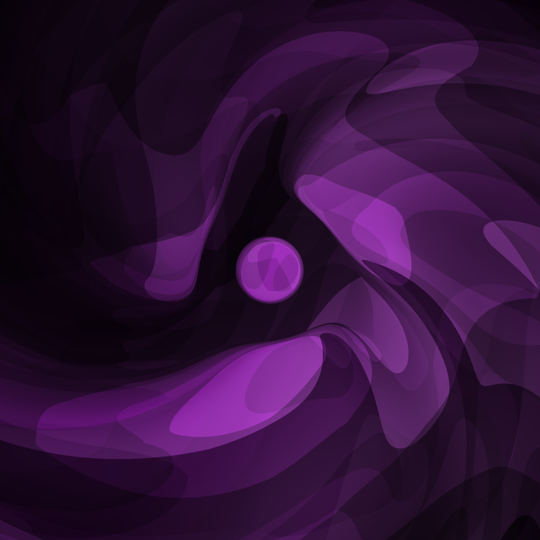

Created frame 401 out of 1200
Creating frame 402 out of 1200
Created frame 402 out of 1200
Creating frame 403 out of 1200
Created frame 403 out of 1200
Creating frame 404 out of 1200
Created frame 404 out of 1200
Creating frame 405 out of 1200
Created frame 405 out of 1200
Creating frame 406 out of 1200
Created frame 406 out of 1200
Creating frame 407 out of 1200
Created frame 407 out of 1200
Creating frame 408 out of 1200
Created frame 408 out of 1200
Creating frame 409 out of 1200
Created frame 409 out of 1200
Creating frame 410 out of 1200
Created frame 410 out of 1200
Creating frame 411 out of 1200
Created frame 411 out of 1200
Creating frame 412 out of 1200
Created frame 412 out of 1200
Creating frame 413 out of 1200
Created frame 413 out of 1200
Creating frame 414 out of 1200
Created frame 414 out of 1200
Creating frame 415 out of 1200
Created frame 415 out of 1200
Creating frame 416 out of 1200
Created frame 416 out of 1200
Creating frame 417 out of 1200
Created frame 417 out of

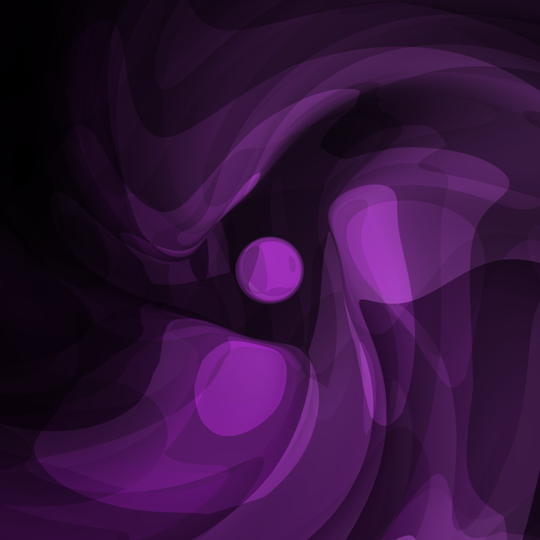

Created frame 501 out of 1200
Creating frame 502 out of 1200
Created frame 502 out of 1200
Creating frame 503 out of 1200
Created frame 503 out of 1200
Creating frame 504 out of 1200
Created frame 504 out of 1200
Creating frame 505 out of 1200
Created frame 505 out of 1200
Creating frame 506 out of 1200
Created frame 506 out of 1200
Creating frame 507 out of 1200
Created frame 507 out of 1200
Creating frame 508 out of 1200
Created frame 508 out of 1200
Creating frame 509 out of 1200
Created frame 509 out of 1200
Creating frame 510 out of 1200
Created frame 510 out of 1200
Creating frame 511 out of 1200
Created frame 511 out of 1200
Creating frame 512 out of 1200
Created frame 512 out of 1200
Creating frame 513 out of 1200
Created frame 513 out of 1200
Creating frame 514 out of 1200
Created frame 514 out of 1200
Creating frame 515 out of 1200
Created frame 515 out of 1200
Creating frame 516 out of 1200
Created frame 516 out of 1200
Creating frame 517 out of 1200
Created frame 517 out of

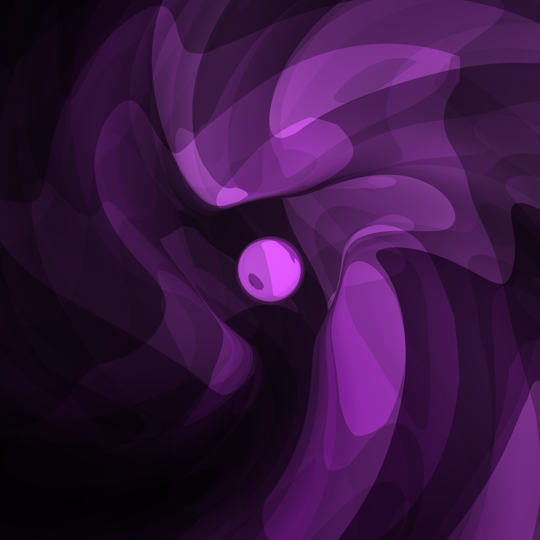

Created frame 601 out of 1200
Creating frame 602 out of 1200
Created frame 602 out of 1200
Creating frame 603 out of 1200
Created frame 603 out of 1200
Creating frame 604 out of 1200
Created frame 604 out of 1200
Creating frame 605 out of 1200
Created frame 605 out of 1200
Creating frame 606 out of 1200
Created frame 606 out of 1200
Creating frame 607 out of 1200
Created frame 607 out of 1200
Creating frame 608 out of 1200
Created frame 608 out of 1200
Creating frame 609 out of 1200
Created frame 609 out of 1200
Creating frame 610 out of 1200
Created frame 610 out of 1200
Creating frame 611 out of 1200
Created frame 611 out of 1200
Creating frame 612 out of 1200
Created frame 612 out of 1200
Creating frame 613 out of 1200
Created frame 613 out of 1200
Creating frame 614 out of 1200
Created frame 614 out of 1200
Creating frame 615 out of 1200
Created frame 615 out of 1200
Creating frame 616 out of 1200
Created frame 616 out of 1200
Creating frame 617 out of 1200
Created frame 617 out of

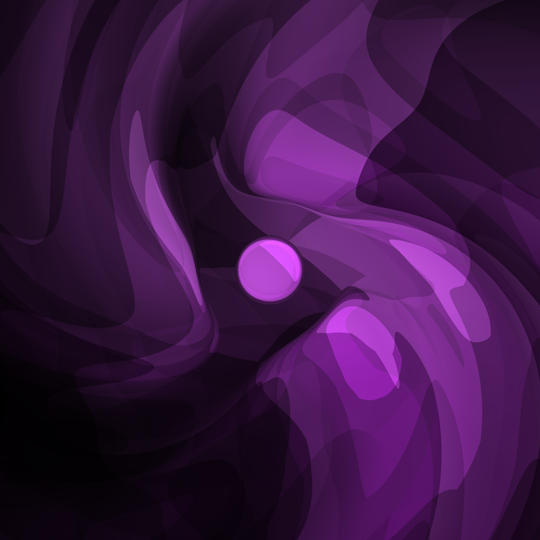

Created frame 701 out of 1200
Creating frame 702 out of 1200
Created frame 702 out of 1200
Creating frame 703 out of 1200
Created frame 703 out of 1200
Creating frame 704 out of 1200
Created frame 704 out of 1200
Creating frame 705 out of 1200
Created frame 705 out of 1200
Creating frame 706 out of 1200
Created frame 706 out of 1200
Creating frame 707 out of 1200
Created frame 707 out of 1200
Creating frame 708 out of 1200
Created frame 708 out of 1200
Creating frame 709 out of 1200
Created frame 709 out of 1200
Creating frame 710 out of 1200
Created frame 710 out of 1200
Creating frame 711 out of 1200
Created frame 711 out of 1200
Creating frame 712 out of 1200
Created frame 712 out of 1200
Creating frame 713 out of 1200
Created frame 713 out of 1200
Creating frame 714 out of 1200
Created frame 714 out of 1200
Creating frame 715 out of 1200
Created frame 715 out of 1200
Creating frame 716 out of 1200
Created frame 716 out of 1200
Creating frame 717 out of 1200
Created frame 717 out of

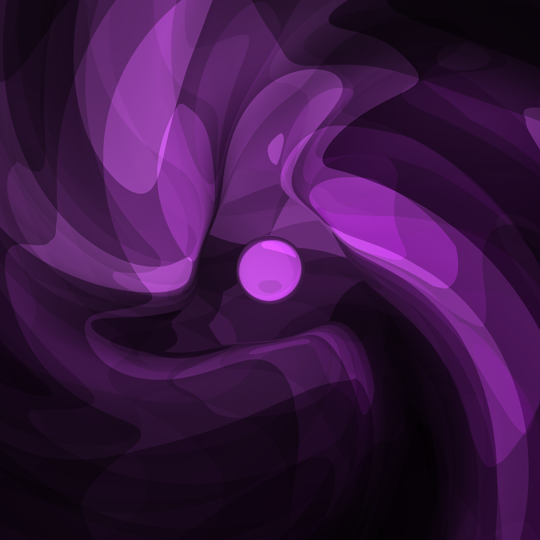

Created frame 801 out of 1200
Creating frame 802 out of 1200
Created frame 802 out of 1200
Creating frame 803 out of 1200
Created frame 803 out of 1200
Creating frame 804 out of 1200
Created frame 804 out of 1200
Creating frame 805 out of 1200
Created frame 805 out of 1200
Creating frame 806 out of 1200
Created frame 806 out of 1200
Creating frame 807 out of 1200
Created frame 807 out of 1200
Creating frame 808 out of 1200
Created frame 808 out of 1200
Creating frame 809 out of 1200
Created frame 809 out of 1200
Creating frame 810 out of 1200
Created frame 810 out of 1200
Creating frame 811 out of 1200
Created frame 811 out of 1200
Creating frame 812 out of 1200
Created frame 812 out of 1200
Creating frame 813 out of 1200
Created frame 813 out of 1200
Creating frame 814 out of 1200
Created frame 814 out of 1200
Creating frame 815 out of 1200
Created frame 815 out of 1200
Creating frame 816 out of 1200
Created frame 816 out of 1200
Creating frame 817 out of 1200
Created frame 817 out of

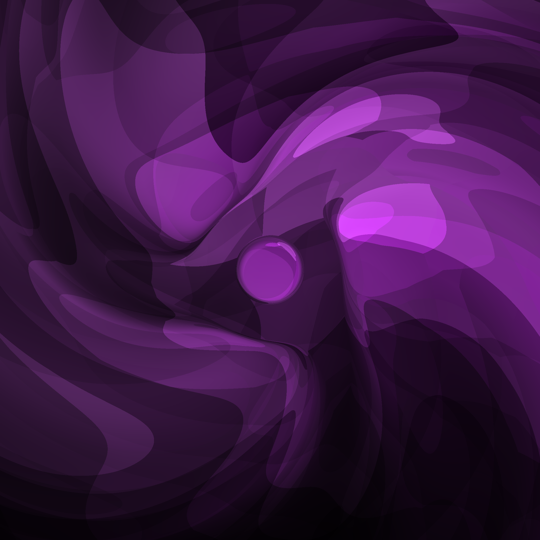

Created frame 901 out of 1200
Creating frame 902 out of 1200
Created frame 902 out of 1200
Creating frame 903 out of 1200
Created frame 903 out of 1200
Creating frame 904 out of 1200
Created frame 904 out of 1200
Creating frame 905 out of 1200
Created frame 905 out of 1200
Creating frame 906 out of 1200
Created frame 906 out of 1200
Creating frame 907 out of 1200
Created frame 907 out of 1200
Creating frame 908 out of 1200
Created frame 908 out of 1200
Creating frame 909 out of 1200
Created frame 909 out of 1200
Creating frame 910 out of 1200
Created frame 910 out of 1200
Creating frame 911 out of 1200
Created frame 911 out of 1200
Creating frame 912 out of 1200
Created frame 912 out of 1200
Creating frame 913 out of 1200
Created frame 913 out of 1200
Creating frame 914 out of 1200
Created frame 914 out of 1200
Creating frame 915 out of 1200
Created frame 915 out of 1200
Creating frame 916 out of 1200
Created frame 916 out of 1200
Creating frame 917 out of 1200
Created frame 917 out of

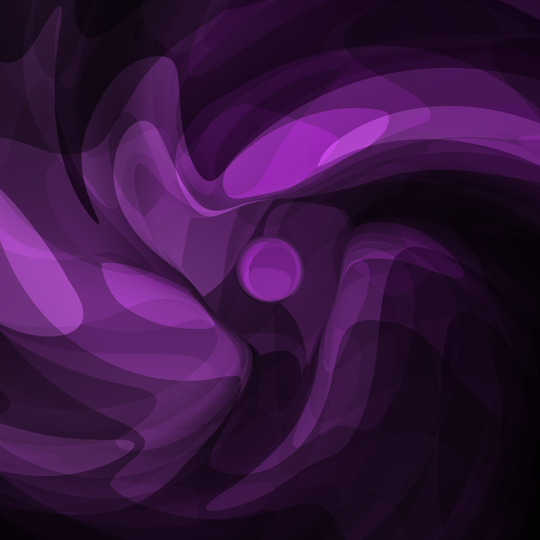

Created frame 1001 out of 1200
Creating frame 1002 out of 1200
Created frame 1002 out of 1200
Creating frame 1003 out of 1200
Created frame 1003 out of 1200
Creating frame 1004 out of 1200
Created frame 1004 out of 1200
Creating frame 1005 out of 1200
Created frame 1005 out of 1200
Creating frame 1006 out of 1200
Created frame 1006 out of 1200
Creating frame 1007 out of 1200
Created frame 1007 out of 1200
Creating frame 1008 out of 1200
Created frame 1008 out of 1200
Creating frame 1009 out of 1200
Created frame 1009 out of 1200
Creating frame 1010 out of 1200
Created frame 1010 out of 1200
Creating frame 1011 out of 1200
Created frame 1011 out of 1200
Creating frame 1012 out of 1200
Created frame 1012 out of 1200
Creating frame 1013 out of 1200
Created frame 1013 out of 1200
Creating frame 1014 out of 1200
Created frame 1014 out of 1200
Creating frame 1015 out of 1200
Created frame 1015 out of 1200
Creating frame 1016 out of 1200
Created frame 1016 out of 1200
Creating frame 1017 out 

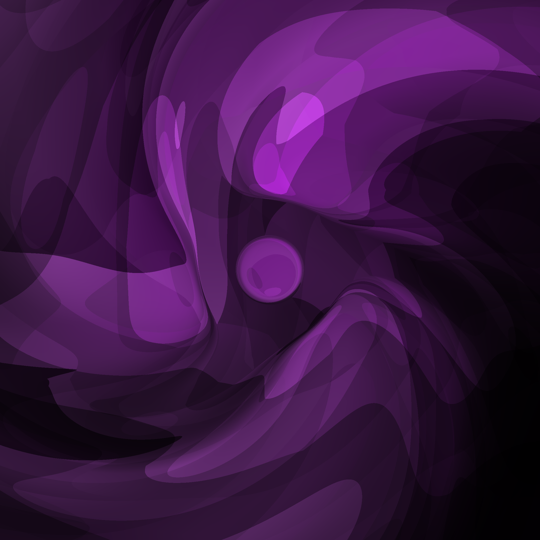

Created frame 1101 out of 1200
Creating frame 1102 out of 1200
Created frame 1102 out of 1200
Creating frame 1103 out of 1200
Created frame 1103 out of 1200
Creating frame 1104 out of 1200
Created frame 1104 out of 1200
Creating frame 1105 out of 1200
Created frame 1105 out of 1200
Creating frame 1106 out of 1200
Created frame 1106 out of 1200
Creating frame 1107 out of 1200
Created frame 1107 out of 1200
Creating frame 1108 out of 1200
Created frame 1108 out of 1200
Creating frame 1109 out of 1200
Created frame 1109 out of 1200
Creating frame 1110 out of 1200
Created frame 1110 out of 1200
Creating frame 1111 out of 1200
Created frame 1111 out of 1200
Creating frame 1112 out of 1200
Created frame 1112 out of 1200
Creating frame 1113 out of 1200
Created frame 1113 out of 1200
Creating frame 1114 out of 1200
Created frame 1114 out of 1200
Creating frame 1115 out of 1200
Created frame 1115 out of 1200
Creating frame 1116 out of 1200
Created frame 1116 out of 1200
Creating frame 1117 out 

0

In [ ]:
frames_in_video = 1200
fps = 60
video_target_resolution = (1080, 1080)
video_generation_resolution = (video_target_resolution[0] * 2, video_target_resolution[1] * 2)
video_preview_resolution = (video_target_resolution[0] // 2, video_target_resolution[1] // 2)
coordinate_scale = 10
show_preview_every_n_frames = 100

coordinates_rotation_phase = AnimationParameter([Keyframe(0, 0), Keyframe(1, -np.pi*2)])
asterisk_rotation_phase = AnimationParameter([Keyframe(0, 0), Keyframe(1, np.pi*2)])
oscilator_progress = AnimationParameter([Keyframe(0, 0), Keyframe(1, np.pi*2)])

video_writer = get_video_writer(video_target_resolution, fps=fps)
for frame_i in range(frames_in_video):
    print(f'Creating frame {frame_i+1} out of {frames_in_video}')
    progress = frame_i / frames_in_video

    input_matrix = generate_input_matrix(
        resolution=video_generation_resolution,
        coordinates_scale=coordinate_scale,
        asterisk_rotation=asterisk_rotation_phase(progress),
        coordinates_rotation=coordinates_rotation_phase(progress),
        oscilator_progress=oscilator_progress(progress),
        oscilator_scale=coordinate_scale / 8
    )

    staircase = (staircase_generator(input_matrix).numpy()[0] + 1) / 2
    generated_frame = matrix_to_image(postprocessing_effect(staircase), min_val=0, max_val=1)

    target_frame = generated_frame.resize(video_target_resolution, resample=Image.BICUBIC)

    if frame_i % show_preview_every_n_frames == 0:
        preview_frame = generated_frame.resize(video_preview_resolution, resample=Image.BICUBIC)
        display(preview_frame)

    video_writer.stdin.write(np.asarray(target_frame).astype('uint8').tobytes())
    print(f'Created frame {frame_i+1} out of {frames_in_video}')
video_writer.stdin.close()
video_writer.wait()